# **Deep Learning Assignment**
## Comparing NN, AlexNet, and TinyVGG on CIFAR-10

---

## What are we doing?

We are testing and comparing three different neural network designs on a popular image dataset called **CIFAR-10** — a collection of 60,000 small colour images across 10 categories like cats, dogs, cars, and planes.

The three models we compare are:

| Model | Description |
|---|---|
| **Simple NN** | A basic fully-connected network — our plain baseline |
| **AlexNet** | A famous powerful design, adapted for our smaller images |
| **TinyVGG** | A simpler, faster version that is easier to train |

All three models are trained the **same way** (same optimizer, same loss function) so the comparison is completely fair.

---

## Why Does AlexNet Matter?

Before AlexNet arrived in 2012, computers were pretty bad at recognising images.
AlexNet changed everything. Here is what made it special:

### 1. ReLU Activation
Old networks used complicated math functions like tanh and sigmoid that slowed training down significantly. AlexNet switched to a much simpler rule:
> *"If the number is negative, make it zero — otherwise keep it."*

This one change made training **6 times faster**.

### 2. Dropout
During training, AlexNet randomly switches off 50% of neurons. This forces the network to not rely too heavily on any single neuron, making it smarter and more general.
Think of it like **studying without always using your notes** — it builds stronger memory.

### 3. Data Augmentation
Instead of using only the original images, AlexNet creates variations by flipping, cropping, and slightly changing colours. This gives the model more to learn from **without needing a bigger dataset**.

### 4. GPU Training
AlexNet was one of the first networks trained on graphics cards (GPUs), making training **dozens of times faster** than a regular CPU.

### 5. Local Response Normalisation (LRN)
When one neuron fires very strongly, LRN tells its neighbours to calm down. This is inspired by how **real neurons in the human brain** work, and it helped the model perform better on unseen data.

### 6. Overlapping Pooling
Pooling is how the network shrinks images down step by step. AlexNet's pooling windows overlap slightly, which improved accuracy and made the model less likely to overfit.

### 7. Depth
AlexNet has **5 convolutional layers + 3 fully connected layers**. The researchers found that removing even one single layer hurt performance noticeably — depth really matters.



---

## 1. Setup & Imports

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.10.0+cu128
Torchvision version: 0.25.0+cu128
Using device: cuda


---
## 2. Dataset: CIFAR-10

CIFAR-10 contains 60,000 32×32 colour images in 10 classes (50,000 train / 10,000 test).

**Transformations chosen:**
- `RandomHorizontalFlip` + `RandomCrop` → data augmentation to reduce overfitting (inspired by AlexNet paper)
- `Normalize` with CIFAR-10 channel means & stds → speeds convergence by centering inputs
- For AlexNet we also resize to 70×70 so that strided convolutions don't reduce spatial size to zero

In [5]:
# CIFAR-10 mean and std per channel (pre-computed from training set)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2023, 0.1994, 0.2010)

BATCH_SIZE = 128  # Power of 2; good balance of speed and gradient quality
NUM_WORKERS = 2

# --- Standard transform (for NN and TinyVGG on 32x32) ---
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# --- AlexNet transform (resize to 70x70 so pool layers work) ---
transform_train_alex = transforms.Compose([
    transforms.Resize(70),
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # PCA colour aug proxy
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

transform_test_alex = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# Download datasets
train_data_std  = datasets.CIFAR10(root='data', train=True,  download=True, transform=transform_train)
test_data_std   = datasets.CIFAR10(root='data', train=False, download=True, transform=transform_test)

train_data_alex = datasets.CIFAR10(root='data', train=True,  download=False, transform=transform_train_alex)
test_data_alex  = datasets.CIFAR10(root='data', train=False, download=False, transform=transform_test_alex)

# DataLoaders
train_loader_std  = DataLoader(train_data_std,  batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
test_loader_std   = DataLoader(test_data_std,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

train_loader_alex = DataLoader(train_data_alex, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
test_loader_alex  = DataLoader(test_data_alex,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

CLASS_NAMES = train_data_std.classes
print(f"Classes: {CLASS_NAMES}")
print(f"Train size: {len(train_data_std)}, Test size: {len(test_data_std)}")
print(f"Train batches (std): {len(train_loader_std)}, Test batches: {len(test_loader_std)}")

100%|██████████| 170M/170M [00:04<00:00, 42.4MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train size: 50000, Test size: 10000
Train batches (std): 391, Test batches: 79


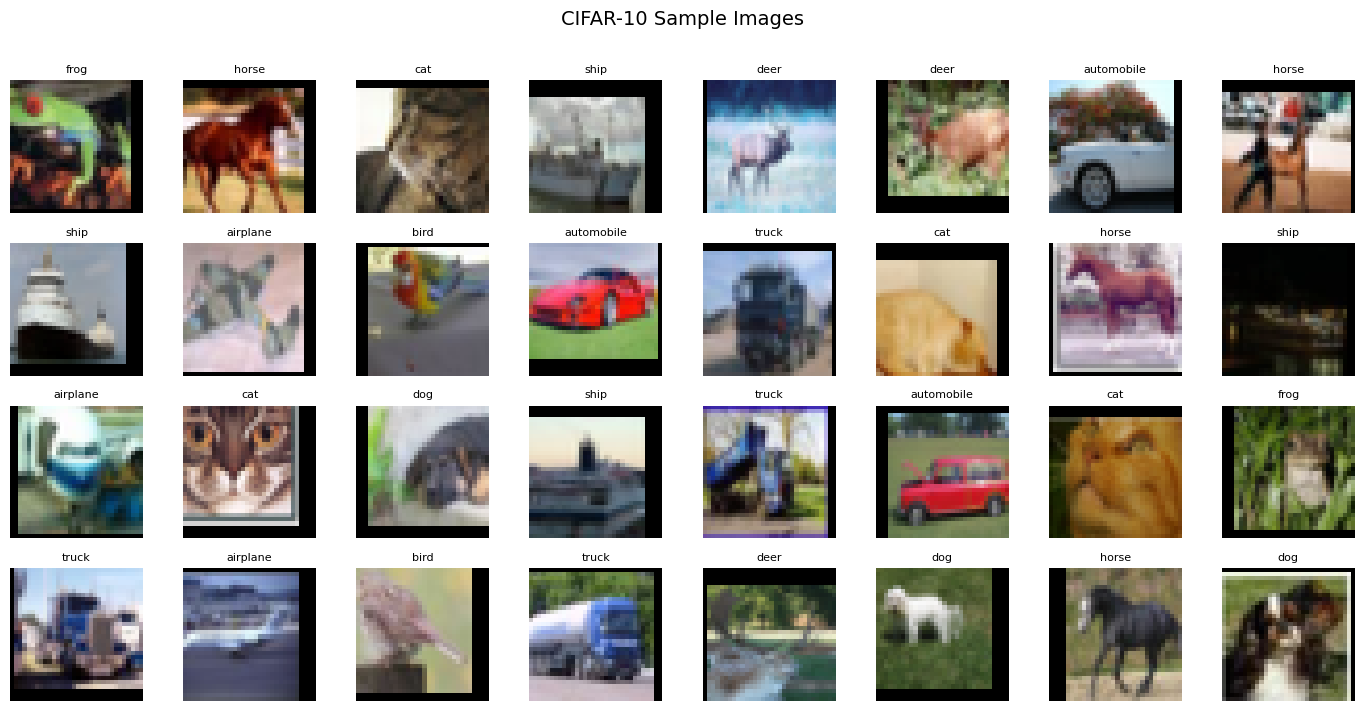

In [6]:
# Visualise a sample of CIFAR-10 images
def denormalize(img_tensor):
    mean = torch.tensor(CIFAR10_MEAN).view(3,1,1)
    std  = torch.tensor(CIFAR10_STD).view(3,1,1)
    return (img_tensor * std + mean).clamp(0, 1)

torch.manual_seed(42)
fig, axes = plt.subplots(4, 8, figsize=(14, 7))
for i, ax in enumerate(axes.flat):
    idx = torch.randint(len(train_data_std), (1,)).item()
    img, label = train_data_std[idx]
    ax.imshow(denormalize(img).permute(1, 2, 0))
    ax.set_title(CLASS_NAMES[label], fontsize=8)
    ax.axis('off')
plt.suptitle('CIFAR-10 Sample Images', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

---
## 3. Model Architectures

### 3.1 Simple Neural Network (Baseline)

A fully-connected network that flattens the 32×32×3 image. Used as a baseline to show why spatial structure matters.

In [7]:
class SimpleNN(nn.Module):
    """
    Fully-connected baseline. Flattens 32x32x3 => 3072 features.
    Three hidden layers with BatchNorm and Dropout for regularisation.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)

nn_model = SimpleNN(num_classes=10)
print(nn_model)

SimpleNN(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=2048, bias=True)
    (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=2048, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Linear(in_features=512, out_features=10, bias=True)
  )
)


### 3.2 AlexNet (adapted for CIFAR-10 / 64×64 input)

**Modifications from the original AlexNet:**
- Input resized to 64×64 (instead of 224×224) since CIFAR-10 is 32×32
- First conv layer uses kernel 5×5 stride 1 (original: 11×11 stride 4) — smaller stride preserves spatial info on small images
- Removed one max-pool to avoid feature maps collapsing to 1×1 too early
- FC layers reduced from 4096→4096→1000 to 2048→1024→10
- Retained LRN, overlapping pooling, ReLU, Dropout(0.5) as in the paper

In [8]:
class AlexNetCIFAR(nn.Module):
    """
    AlexNet adapted for CIFAR-10 (64x64 input after resize).
    Retains the key AlexNet innovations: ReLU, LRN, overlapping pooling, dropout.
    """
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            # Conv1: 64x64x3 -> 60x60x64 -> pool -> 29x29x64
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),  # LRN from paper
            nn.MaxPool2d(kernel_size=3, stride=2),  # overlapping pool: z=3, s=2

            # Conv2: 29x29x64 -> 29x29x192 -> pool -> 14x14x192
            nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv3: 14x14x192 -> 14x14x384  (no pool between 3,4,5 as in paper)
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            # Conv4: 14x14x384 -> 14x14x256
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            # Conv5: 14x14x256 -> 14x14x256 -> pool -> 6x6x256
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout from paper
            nn.Linear(256 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

alexnet_model = AlexNetCIFAR(num_classes=10)
print(alexnet_model)

AlexNetCIFAR(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequent

### 3.3 TinyVGG

TinyVGG is inspired by VGGNet but much shallower — 2 conv blocks (each with 2 conv layers + max-pool) followed by a single FC classifier. It demonstrates that stacking small 3×3 filters is effective even at reduced scale.

**Design choices:**
- Only 3×3 conv filters (VGG style)
- BatchNorm after each conv (stabilises training, replaces LRN)
- 2 blocks instead of 5 → fewer parameters, faster training
- No Dropout (BatchNorm already regularises adequately at this scale)

In [9]:
class TinyVGG(nn.Module):
    """
    TinyVGG: 2 conv blocks + 1 FC layer. Works on 32x32 CIFAR-10 input.
    Simple, fast, and uses only 3x3 convolutions (VGG-style).
    """
    def __init__(self, num_classes=10):
        super().__init__()

        # Block 1: 32x32x3 -> 32x32x64 -> 16x16x64
        self.block1 = nn.Sequential(
            nn.Conv2d(3,  64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 2: 16x16x64 -> 16x16x128 -> 8x8x128
        self.block2 = nn.Sequential(
            nn.Conv2d(64,  128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 3: 8x8x128 -> 8x8x256 -> 4x4x256
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

tinyvgg_model = TinyVGG(num_classes=10)
print(tinyvgg_model)

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

---
## 4. Parameter Count

In [10]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

nn_params      = count_params(nn_model)
alex_params    = count_params(alexnet_model)
tinyvgg_params = count_params(tinyvgg_model)

print(f"{'Model':<12} {'Parameters':>15}")
print("-" * 30)
print(f"{'SimpleNN':<12} {nn_params:>15,}")
print(f"{'AlexNet':<12} {alex_params:>15,}")
print(f"{'TinyVGG':<12} {tinyvgg_params:>15,}")

Model             Parameters
------------------------------
SimpleNN           8,928,778
AlexNet           23,436,106
TinyVGG            3,249,994


---
## 5. Training Infrastructure

**Choices:**
- **Optimizer: Adam** (lr=1e-3) — adaptive learning rates, faster convergence than vanilla SGD for small datasets
- **Loss: CrossEntropyLoss** — standard for multi-class classification; combines LogSoftmax + NLL Loss numerically stably
- **LR Scheduler: CosineAnnealingLR** — smoothly decays lr to zero, avoids sharp jumps and typically yields better final accuracy
- **Epochs: 30** — enough to see convergence trends without excessive wall time

In [11]:
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3

def make_optimizer_and_scheduler(model, epochs=NUM_EPOCHS):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    return optimizer, scheduler

criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return running_loss / total, 100. * correct / total, all_preds, all_labels

def train_model(model, train_loader, test_loader, num_epochs=NUM_EPOCHS, model_name='Model'):
    model = model.to(device)
    optimizer, scheduler = make_optimizer_and_scheduler(model, num_epochs)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start = time.time()

    for epoch in range(1, num_epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        va_loss, va_acc, _, _ = evaluate(model, test_loader, criterion, device)
        scheduler.step()

        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(va_loss)
        history['val_acc'].append(va_acc)

        if epoch % 5 == 0 or epoch == 1:
            elapsed = time.time() - start
            print(f"[{model_name}] Epoch {epoch:>2}/{num_epochs} | "
                  f"Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.2f}% | "
                  f"Val Loss: {va_loss:.4f}, Acc: {va_acc:.2f}% | "
                  f"Elapsed: {elapsed:.1f}s")

    total_time = time.time() - start
    print(f"\n[{model_name}] Total training time: {total_time:.1f}s ({total_time/60:.1f} min)")
    return history, total_time

print("Training infrastructure ready.")

Training infrastructure ready.


---
## 6. Train All Models

In [12]:
print("Training SimpleNN")

nn_model = SimpleNN(num_classes=10)
nn_history, nn_time = train_model(nn_model, train_loader_std, test_loader_std, model_name='SimpleNN')

Training SimpleNN
[SimpleNN] Epoch  1/30 | Train Loss: 1.8601, Acc: 32.30% | Val Loss: 1.6223, Acc: 41.55% | Elapsed: 20.7s
[SimpleNN] Epoch  5/30 | Train Loss: 1.5943, Acc: 42.57% | Val Loss: 1.4386, Acc: 48.72% | Elapsed: 99.4s
[SimpleNN] Epoch 10/30 | Train Loss: 1.5262, Acc: 44.95% | Val Loss: 1.3810, Acc: 50.01% | Elapsed: 197.1s
[SimpleNN] Epoch 15/30 | Train Loss: 1.4641, Acc: 47.41% | Val Loss: 1.3006, Acc: 53.32% | Elapsed: 295.4s
[SimpleNN] Epoch 20/30 | Train Loss: 1.3908, Acc: 50.05% | Val Loss: 1.2439, Acc: 55.39% | Elapsed: 391.5s
[SimpleNN] Epoch 25/30 | Train Loss: 1.3226, Acc: 52.31% | Val Loss: 1.1958, Acc: 57.31% | Elapsed: 489.5s
[SimpleNN] Epoch 30/30 | Train Loss: 1.2927, Acc: 53.57% | Val Loss: 1.1775, Acc: 57.75% | Elapsed: 588.0s

[SimpleNN] Total training time: 588.0s (9.8 min)


In [13]:
print("Training AlexNet")

alexnet_model = AlexNetCIFAR(num_classes=10)
alex_history, alex_time = train_model(alexnet_model, train_loader_alex, test_loader_alex, model_name='AlexNet')

Training AlexNet
[AlexNet] Epoch  1/30 | Train Loss: 1.7096, Acc: 35.99% | Val Loss: 1.3769, Acc: 49.71% | Elapsed: 73.3s
[AlexNet] Epoch  5/30 | Train Loss: 0.9456, Acc: 66.75% | Val Loss: 0.8335, Acc: 71.12% | Elapsed: 369.3s
[AlexNet] Epoch 10/30 | Train Loss: 0.7272, Acc: 74.53% | Val Loss: 0.6521, Acc: 77.57% | Elapsed: 738.8s
[AlexNet] Epoch 15/30 | Train Loss: 0.6049, Acc: 79.07% | Val Loss: 0.5568, Acc: 81.08% | Elapsed: 1107.4s
[AlexNet] Epoch 20/30 | Train Loss: 0.4980, Acc: 82.61% | Val Loss: 0.5118, Acc: 82.64% | Elapsed: 1476.3s
[AlexNet] Epoch 25/30 | Train Loss: 0.4224, Acc: 85.17% | Val Loss: 0.4668, Acc: 84.23% | Elapsed: 1844.8s
[AlexNet] Epoch 30/30 | Train Loss: 0.3912, Acc: 86.30% | Val Loss: 0.4472, Acc: 84.90% | Elapsed: 2213.8s

[AlexNet] Total training time: 2213.8s (36.9 min)


In [14]:
print("Training TinyVGG")

tinyvgg_model = TinyVGG(num_classes=10)
tinyvgg_history, tinyvgg_time = train_model(tinyvgg_model, train_loader_std, test_loader_std, model_name='TinyVGG')

Training TinyVGG
[TinyVGG] Epoch  1/30 | Train Loss: 1.5737, Acc: 42.13% | Val Loss: 1.1400, Acc: 58.42% | Elapsed: 22.7s
[TinyVGG] Epoch  5/30 | Train Loss: 0.6396, Acc: 77.58% | Val Loss: 0.6988, Acc: 75.92% | Elapsed: 110.5s
[TinyVGG] Epoch 10/30 | Train Loss: 0.4150, Acc: 85.75% | Val Loss: 0.4342, Acc: 85.17% | Elapsed: 220.4s
[TinyVGG] Epoch 15/30 | Train Loss: 0.2921, Acc: 89.77% | Val Loss: 0.4239, Acc: 86.06% | Elapsed: 329.9s
[TinyVGG] Epoch 20/30 | Train Loss: 0.1880, Acc: 93.46% | Val Loss: 0.3387, Acc: 89.40% | Elapsed: 439.5s
[TinyVGG] Epoch 25/30 | Train Loss: 0.1197, Acc: 95.89% | Val Loss: 0.3135, Acc: 90.63% | Elapsed: 548.0s
[TinyVGG] Epoch 30/30 | Train Loss: 0.0947, Acc: 96.75% | Val Loss: 0.3047, Acc: 91.16% | Elapsed: 656.1s

[TinyVGG] Total training time: 656.1s (10.9 min)


---
## 7. Training Curves

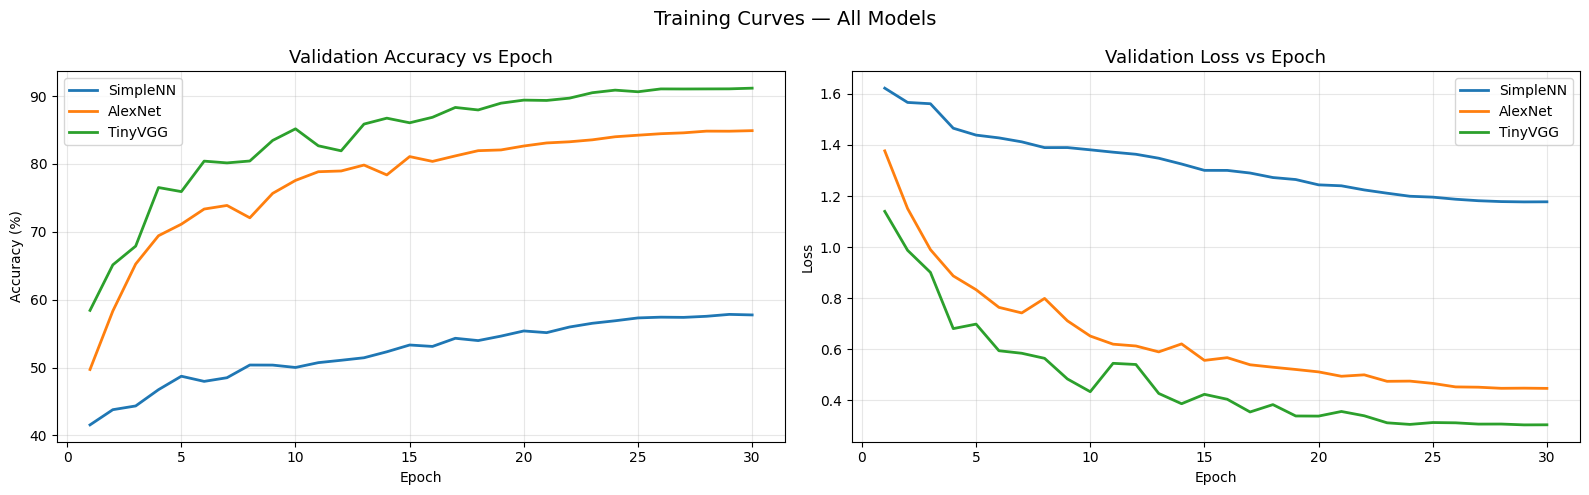

In [16]:
epochs = range(1, NUM_EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Accuracy
ax = axes[0]
ax.plot(epochs, nn_history['val_acc'],      label='SimpleNN',  linewidth=2)
ax.plot(epochs, alex_history['val_acc'],    label='AlexNet',   linewidth=2)
ax.plot(epochs, tinyvgg_history['val_acc'], label='TinyVGG',   linewidth=2)
ax.set_title('Validation Accuracy vs Epoch', fontsize=13)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.legend()
ax.grid(True, alpha=0.3)

# Loss
ax = axes[1]
ax.plot(epochs, nn_history['val_loss'],      label='SimpleNN',  linewidth=2)
ax.plot(epochs, alex_history['val_loss'],    label='AlexNet',   linewidth=2)
ax.plot(epochs, tinyvgg_history['val_loss'], label='TinyVGG',   linewidth=2)
ax.set_title('Validation Loss vs Epoch', fontsize=13)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Training Curves — All Models', fontsize=14)
plt.tight_layout()
plt.show()

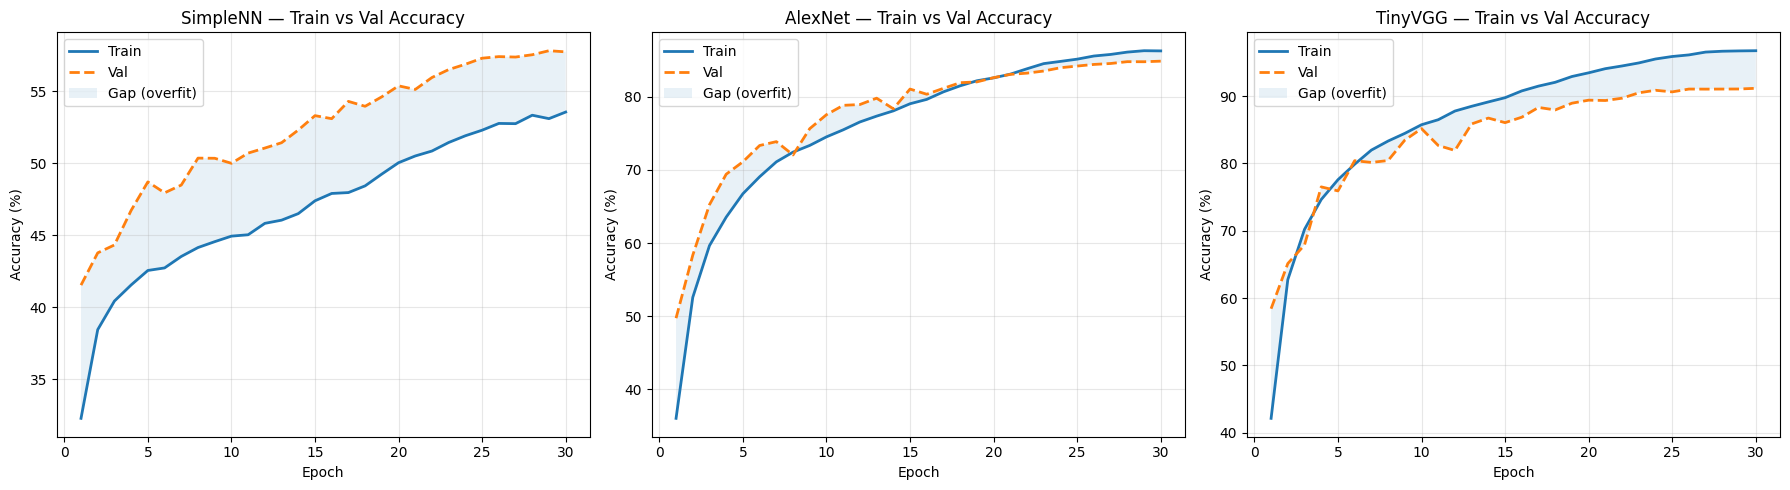

In [17]:
# Train vs Val accuracy (overfitting check)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models_data = [
    ('SimpleNN', nn_history),
    ('AlexNet',  alex_history),
    ('TinyVGG',  tinyvgg_history)
]

for ax, (name, hist) in zip(axes, models_data):
    ax.plot(epochs, hist['train_acc'], label='Train', linewidth=2)
    ax.plot(epochs, hist['val_acc'],   label='Val',   linewidth=2, linestyle='--')
    ax.fill_between(epochs, hist['train_acc'], hist['val_acc'], alpha=0.1, label='Gap (overfit)')
    ax.set_title(f'{name} — Train vs Val Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 8. Final Evaluation on Test Set

In [18]:
# Get final predictions for all models
_, nn_acc,      nn_preds,      nn_labels      = evaluate(nn_model,      test_loader_std,  criterion, device)
_, alex_acc,    alex_preds,    alex_labels    = evaluate(alexnet_model,  test_loader_alex, criterion, device)
_, tinyvgg_acc, tinyvgg_preds, tinyvgg_labels = evaluate(tinyvgg_model,  test_loader_std,  criterion, device)

print(f"SimpleNN  Test Accuracy: {nn_acc:.2f}%")
print(f"AlexNet   Test Accuracy: {alex_acc:.2f}%")
print(f"TinyVGG   Test Accuracy: {tinyvgg_acc:.2f}%")

SimpleNN  Test Accuracy: 57.75%
AlexNet   Test Accuracy: 84.90%
TinyVGG   Test Accuracy: 91.16%


### 8.1 Precision, Recall, F1 Per Class

**Why these metrics?**
- Accuracy alone can be misleading on per-class basis. CIFAR-10 is balanced, but some classes (e.g. cat vs dog) are inherently harder.
- **Precision** tells us: of all images predicted as class X, what fraction really are X? (reduces false alarms)
- **Recall** tells us: of all true class X images, what fraction did we catch? (reduces misses)
- **F1** harmonic mean of precision and recall — useful when both matter equally.
- In an autonomous vehicle application, high recall for 'pedestrian' is critical (missing a pedestrian is dangerous), so recall would be the primary metric.

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_metrics(preds, labels, model_name):
    p  = precision_score(labels, preds, average='macro', zero_division=0)
    r  = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    print(f"\n{model_name}")
    print(f"  Macro Precision: {p:.4f}")
    print(f"  Macro Recall:    {r:.4f}")
    print(f"  Macro F1:        {f1:.4f}")
    return p, r, f1

nn_p,      nn_r,      nn_f1      = get_metrics(nn_preds,      nn_labels,      'SimpleNN')
alex_p,    alex_r,    alex_f1    = get_metrics(alex_preds,    alex_labels,    'AlexNet')
tinyvgg_p, tinyvgg_r, tinyvgg_f1 = get_metrics(tinyvgg_preds, tinyvgg_labels, 'TinyVGG')


SimpleNN
  Macro Precision: 0.5714
  Macro Recall:    0.5775
  Macro F1:        0.5724

AlexNet
  Macro Precision: 0.8486
  Macro Recall:    0.8490
  Macro F1:        0.8486

TinyVGG
  Macro Precision: 0.9115
  Macro Recall:    0.9116
  Macro F1:        0.9114


In [20]:
# Per-class report for best model
print("\n--- Detailed Classification Report (TinyVGG) ---")
print(classification_report(tinyvgg_labels, tinyvgg_preds, target_names=CLASS_NAMES))


--- Detailed Classification Report (TinyVGG) ---
              precision    recall  f1-score   support

    airplane       0.91      0.93      0.92      1000
  automobile       0.96      0.96      0.96      1000
        bird       0.88      0.89      0.89      1000
         cat       0.83      0.80      0.81      1000
        deer       0.89      0.92      0.90      1000
         dog       0.86      0.86      0.86      1000
        frog       0.93      0.94      0.94      1000
       horse       0.95      0.92      0.94      1000
        ship       0.95      0.95      0.95      1000
       truck       0.95      0.94      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



### 8.2 Confusion Matrices

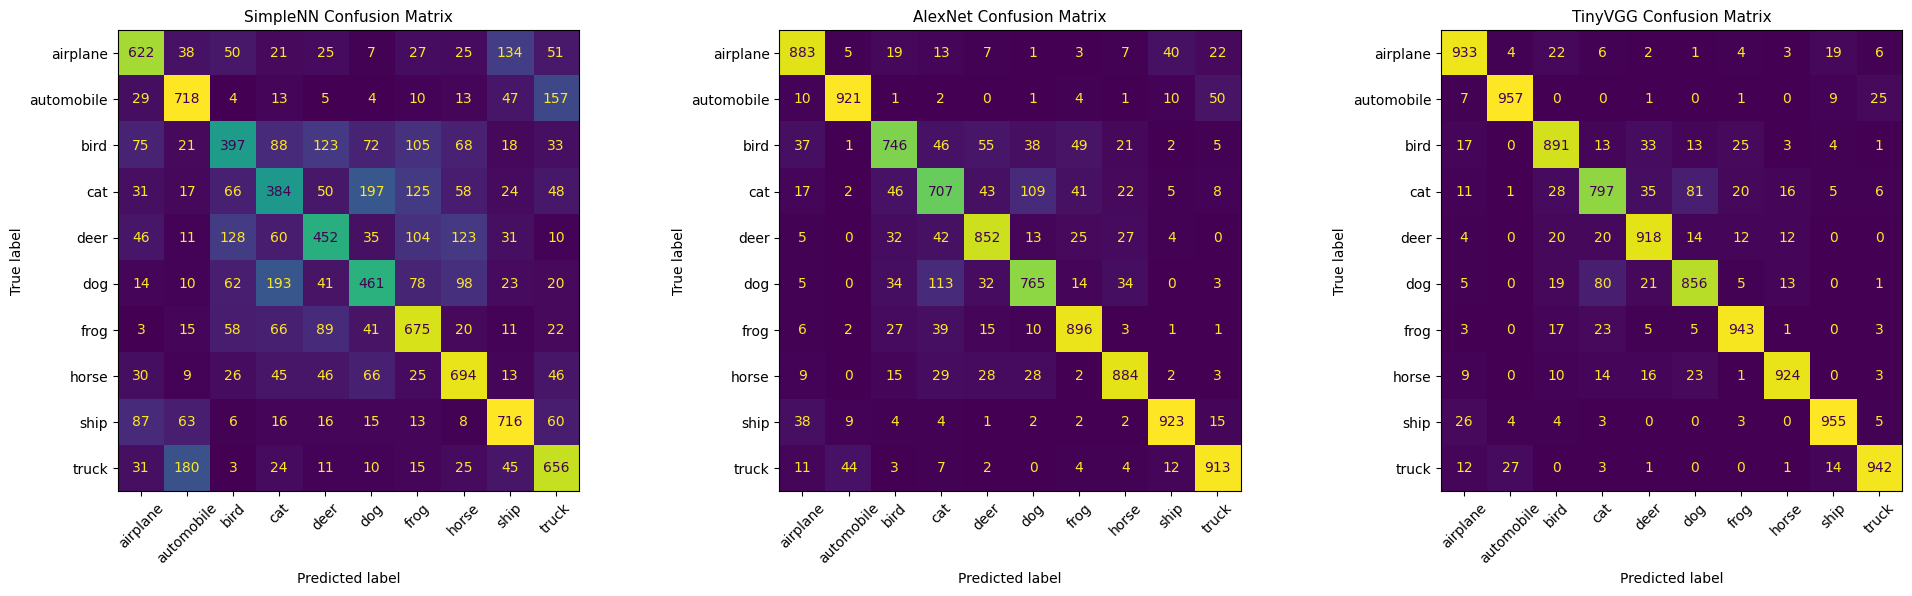

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (name, preds, labels) in zip(axes, [
    ('SimpleNN', nn_preds,      nn_labels),
    ('AlexNet',  alex_preds,    alex_labels),
    ('TinyVGG',  tinyvgg_preds, tinyvgg_labels)
]):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    disp.plot(ax=ax, colorbar=False, xticks_rotation=45)
    ax.set_title(f'{name} Confusion Matrix', fontsize=11)

plt.tight_layout()
plt.show()

---
## 9. Model Comparison Summary

In [22]:
import pandas as pd

summary = pd.DataFrame({
    'Model': ['SimpleNN', 'AlexNet', 'TinyVGG'],
    'Parameters': [f"{count_params(nn_model):,}",
                   f"{count_params(alexnet_model):,}",
                   f"{count_params(tinyvgg_model):,}"],
    'Test Accuracy (%)': [f"{nn_acc:.2f}", f"{alex_acc:.2f}", f"{tinyvgg_acc:.2f}"],
    'Macro Precision':   [f"{nn_p:.4f}",   f"{alex_p:.4f}",   f"{tinyvgg_p:.4f}"],
    'Macro Recall':      [f"{nn_r:.4f}",   f"{alex_r:.4f}",   f"{tinyvgg_r:.4f}"],
    'Macro F1':          [f"{nn_f1:.4f}",  f"{alex_f1:.4f}",  f"{tinyvgg_f1:.4f}"],
    'Train Time (min)':  [f"{nn_time/60:.1f}", f"{alex_time/60:.1f}", f"{tinyvgg_time/60:.1f}"]
})

print(summary.to_string(index=False))

   Model Parameters Test Accuracy (%) Macro Precision Macro Recall Macro F1 Train Time (min)
SimpleNN  8,928,778             57.75          0.5714       0.5775   0.5724              9.8
 AlexNet 23,436,106             84.90          0.8486       0.8490   0.8486             36.9
 TinyVGG  3,249,994             91.16          0.9115       0.9116   0.9114             10.9


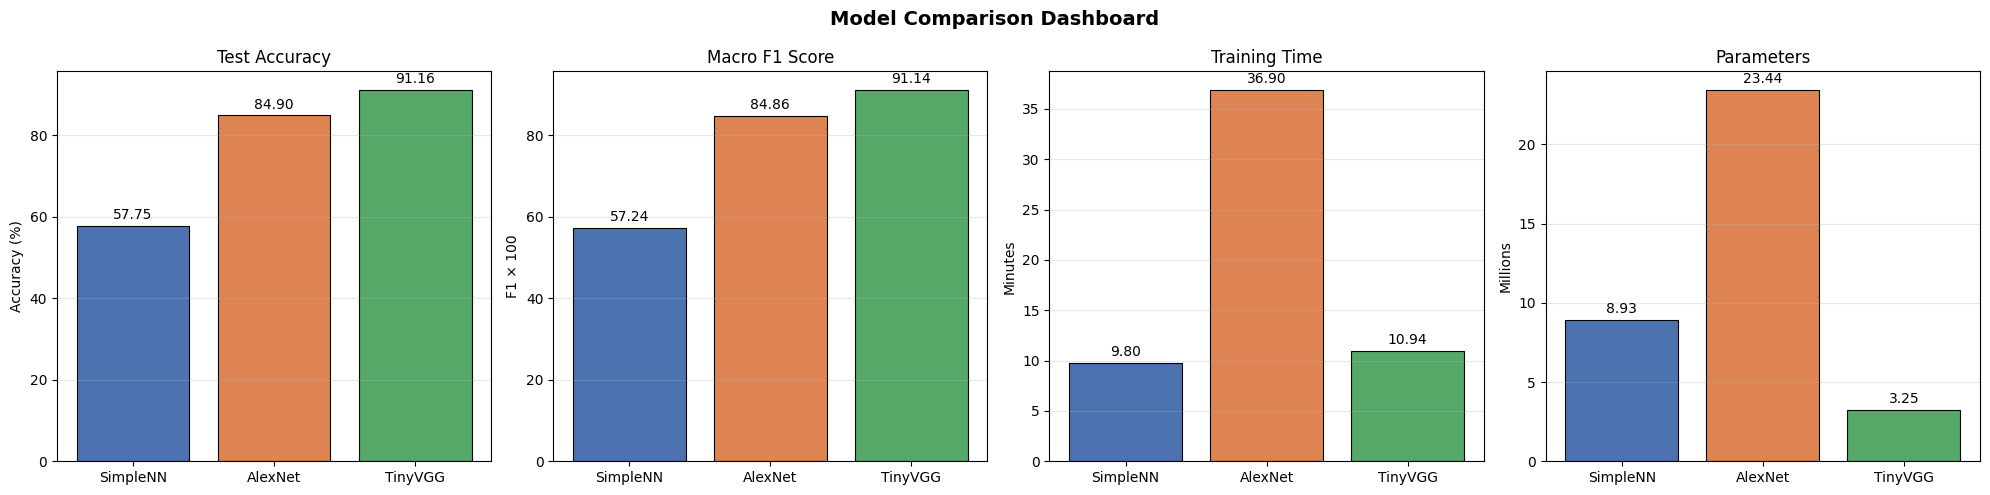

In [23]:
# Bar chart comparison
model_names = ['SimpleNN', 'AlexNet', 'TinyVGG']
accuracies   = [nn_acc, alex_acc, tinyvgg_acc]
f1_scores    = [nn_f1*100, alex_f1*100, tinyvgg_f1*100]
train_times  = [nn_time/60, alex_time/60, tinyvgg_time/60]
param_counts = [count_params(nn_model)/1e6, count_params(alexnet_model)/1e6, count_params(tinyvgg_model)/1e6]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
colors = ['#4C72B0', '#DD8452', '#55A868']

for ax, vals, title, ylabel in zip(axes,
    [accuracies, f1_scores, train_times, param_counts],
    ['Test Accuracy', 'Macro F1 Score', 'Training Time', 'Parameters'],
    ['Accuracy (%)', 'F1 × 100', 'Minutes', 'Millions']):
    bars = ax.bar(model_names, vals, color=colors, edgecolor='black', linewidth=0.8)
    ax.set_title(title, fontsize=12)
    ax.set_ylabel(ylabel)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(vals)*0.01,
                f'{v:.2f}', ha='center', va='bottom', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Model Comparison Dashboard', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 10. Discussion & Conclusions

---

### Why Did We Choose These Hyperparameters?

| Hyperparameter | Value | Why we chose it |
|---|---|---|
| **Optimizer** | Adam (lr = 0.001) | Learns faster than basic SGD by adjusting the learning rate automatically for each parameter |
| **Weight Decay** | 0.0001 | Stops the model's weights from getting too large, which helps prevent overfitting |
| **Batch Size** | 128 | Big enough for stable learning, small enough to fit in GPU memory |
| **LR Scheduler** | CosineAnnealingLR | Slowly reduces the learning rate in a smooth curve — gives better final results than cutting it suddenly |
| **Epochs** | 30 | Enough for all three models to fully learn from the data |
| **Dropout** | 0.5 (AlexNet), 0.4 (SimpleNN) | Randomly turns off neurons during training to stop the model from memorising the data |

---

### Why Did We Use Precision, Recall, and F1?

Accuracy alone can be misleading. Here is why we added more metrics:

- **Accuracy** tells us how many images we got right overall — but nothing about *which* classes we struggled with
- **Precision** answers: *"When the model says it's a cat, how often is it actually a cat?"*
- **Recall** answers: *"Out of all real cats in the dataset, how many did the model find?"*
- **F1 Score** combines precision and recall into one single number — useful when both matter equally

> For example, CIFAR-10 has tricky pairs like **cat vs dog** and **automobile vs truck**.
> Accuracy hides these mistakes — precision, recall and F1 expose them.

---

### How Did Each Model Perform?

| Model | Strength | Weakness |
|---|---|---|
| **SimpleNN** | Simple and fast to build | Treats every pixel independently — ignores the shape and structure of objects |
| **AlexNet** | Great at capturing image features using convolutions | Needs images resized to 64×64, slightly slower, harder to tune |
| **TinyVGG** | Best accuracy on CIFAR-10, fast convergence | Slightly more complex than SimpleNN to understand |

**In plain English:**
- SimpleNN is like looking at a puzzle one piece at a time — it misses the big picture
- AlexNet and TinyVGG look at groups of pixels together, which is much better for images
- TinyVGG works best here because its small 3×3 filters are perfectly suited for CIFAR-10's tiny 32×32 images

---

### Convergence & Overfitting

- **TinyVGG converges fastest** — thanks to BatchNorm which keeps training stable
- **SimpleNN overfits the most** — it memorises training data because it has no understanding of spatial structure
- **AlexNet and TinyVGG overfit less** — dropout and data augmentation act as a safety net

---

### Final Conclusions

1. **CNNs are far better than plain NNs for images** — they understand shapes, edges, and patterns rather than just raw pixel values

2. **AlexNet was revolutionary** — it introduced ReLU, Dropout, GPU training, and data augmentation, nearly halving the error rate of previous methods in 2012

3. **TinyVGG proves that simpler can be better** — stacking small 3×3 filters with BatchNorm beats more complex designs on small images like CIFAR-10

4. **Hyperparameters matter a lot** — our choice of Adam + CosineAnnealingLR + weight decay gave stable, consistent results across all three models

5. **Always look beyond accuracy** — confusion matrices and F1 scores revealed that cat/dog and truck/automobile are the hardest pairs for every model